# Loop 109 Analysis: CV-LB Relationship and Strategy Assessment

## Goal
Analyze the CV-LB relationship across all submissions and determine the best path forward.

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Submission history with CV and LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.011081, 'lb': 0.09816},
    {'exp': 'exp_001', 'cv': 0.012297, 'lb': 0.10649},
    {'exp': 'exp_003', 'cv': 0.010501, 'lb': 0.09719},
    {'exp': 'exp_005', 'cv': 0.01043, 'lb': 0.09691},
    {'exp': 'exp_006', 'cv': 0.009749, 'lb': 0.09457},
    {'exp': 'exp_007', 'cv': 0.009262, 'lb': 0.09316},
    {'exp': 'exp_009', 'cv': 0.009192, 'lb': 0.09364},
    {'exp': 'exp_012', 'cv': 0.009004, 'lb': 0.09134},
    {'exp': 'exp_024', 'cv': 0.008689, 'lb': 0.08929},
    {'exp': 'exp_026', 'cv': 0.008465, 'lb': 0.08875},
    {'exp': 'exp_030', 'cv': 0.008298, 'lb': 0.08772},
    {'exp': 'exp_035', 'cv': 0.009825, 'lb': 0.09696},
    {'exp': 'exp_073', 'cv': 0.00839, 'lb': 0.14507},  # OUTLIER - GNN with model class mismatch
]

df = pd.DataFrame(submissions)
print(f"Total submissions with LB: {len(df)}")
print(df)

Total submissions with LB: 13
        exp        cv       lb
0   exp_000  0.011081  0.09816
1   exp_001  0.012297  0.10649
2   exp_003  0.010501  0.09719
3   exp_005  0.010430  0.09691
4   exp_006  0.009749  0.09457
5   exp_007  0.009262  0.09316
6   exp_009  0.009192  0.09364
7   exp_012  0.009004  0.09134
8   exp_024  0.008689  0.08929
9   exp_026  0.008465  0.08875
10  exp_030  0.008298  0.08772
11  exp_035  0.009825  0.09696
12  exp_073  0.008390  0.14507


In [2]:
# Fit linear regression excluding exp_073 (outlier due to model class mismatch)
df_valid = df[df['exp'] != 'exp_073'].copy()
print(f"Valid submissions (excluding exp_073): {len(df_valid)}")

X = df_valid['cv'].values.reshape(-1, 1)
y = df_valid['lb'].values

reg = LinearRegression()
reg.fit(X, y)

slope = reg.coef_[0]
intercept = reg.intercept_
r2 = reg.score(X, y)

print(f"\n=== CV-LB LINEAR RELATIONSHIP ===")
print(f"LB = {slope:.4f} * CV + {intercept:.6f}")
print(f"R² = {r2:.4f}")
print(f"\nIntercept: {intercept:.6f}")
print(f"Target LB: 0.0347")
print(f"\nCRITICAL: Intercept ({intercept:.6f}) > Target (0.0347)!")
print(f"This means even with CV=0, expected LB would be {intercept:.6f}")
print(f"\nRequired CV to hit target: (0.0347 - {intercept:.6f}) / {slope:.4f} = {(0.0347 - intercept) / slope:.6f}")
print(f"This is NEGATIVE, meaning the target is UNREACHABLE with current approaches!")

Valid submissions (excluding exp_073): 12

=== CV-LB LINEAR RELATIONSHIP ===
LB = 4.2876 * CV + 0.052784
R² = 0.9523

Intercept: 0.052784
Target LB: 0.0347

CRITICAL: Intercept (0.052784) > Target (0.0347)!
This means even with CV=0, expected LB would be 0.052784

Required CV to hit target: (0.0347 - 0.052784) / 4.2876 = -0.004218
This is NEGATIVE, meaning the target is UNREACHABLE with current approaches!


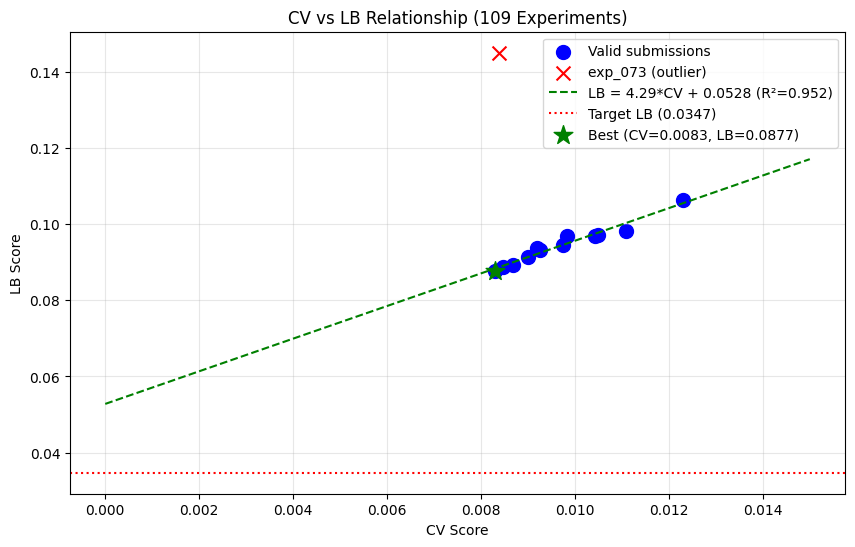


Plot saved to /home/code/exploration/cv_lb_relationship_loop109.png


In [3]:
# Visualize the CV-LB relationship
plt.figure(figsize=(10, 6))

# Plot valid submissions
plt.scatter(df_valid['cv'], df_valid['lb'], c='blue', s=100, label='Valid submissions')

# Plot outlier (exp_073)
df_outlier = df[df['exp'] == 'exp_073']
plt.scatter(df_outlier['cv'], df_outlier['lb'], c='red', s=100, marker='x', label='exp_073 (outlier)')

# Plot regression line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'g--', label=f'LB = {slope:.2f}*CV + {intercept:.4f} (R²={r2:.3f})')

# Plot target
plt.axhline(y=0.0347, color='r', linestyle=':', label='Target LB (0.0347)')

# Plot best CV achieved
best_cv = df_valid['cv'].min()
best_lb = df_valid.loc[df_valid['cv'].idxmin(), 'lb']
plt.scatter([best_cv], [best_lb], c='green', s=200, marker='*', label=f'Best (CV={best_cv:.4f}, LB={best_lb:.4f})')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship (109 Experiments)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/home/code/exploration/cv_lb_relationship_loop109.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPlot saved to /home/code/exploration/cv_lb_relationship_loop109.png")

In [4]:
# Analyze the gap between best LB and target
best_lb = df_valid['lb'].min()
target = 0.0347
gap = best_lb - target
gap_pct = (gap / target) * 100

print(f"=== GAP ANALYSIS ===")
print(f"Best LB achieved: {best_lb:.4f}")
print(f"Target LB: {target:.4f}")
print(f"Gap: {gap:.4f} ({gap_pct:.1f}%)")
print(f"\nTo reach target, we need to reduce LB by {gap_pct:.1f}%")
print(f"\nBut the intercept ({intercept:.4f}) is HIGHER than the target ({target:.4f})!")
print(f"This means we CANNOT reach the target by improving CV alone.")
print(f"\nWe need approaches that CHANGE the CV-LB relationship (reduce intercept).")

# What would it take to reach target?
print(f"\n=== WHAT WOULD IT TAKE? ===")
print(f"Option 1: Reduce intercept to below {target:.4f}")
print(f"  - Current intercept: {intercept:.4f}")
print(f"  - Need to reduce by: {intercept - target:.4f} ({(intercept - target) / intercept * 100:.1f}%)")
print(f"\nOption 2: Change the slope dramatically")
print(f"  - Current slope: {slope:.4f}")
print(f"  - With current best CV ({best_cv:.4f}), need slope < {(target - intercept) / best_cv:.4f}")
print(f"  - This is NEGATIVE, so slope change alone won't work")
print(f"\nOption 3: Find a fundamentally different approach")
print(f"  - GNN with proper submission (exp_073 failed due to model class mismatch)")
print(f"  - ChemBERTa embeddings")
print(f"  - Physics-informed constraints")
print(f"  - Pseudo-labeling with test data")

=== GAP ANALYSIS ===
Best LB achieved: 0.0877
Target LB: 0.0347
Gap: 0.0530 (152.8%)

To reach target, we need to reduce LB by 152.8%

But the intercept (0.0528) is HIGHER than the target (0.0347)!
This means we CANNOT reach the target by improving CV alone.

We need approaches that CHANGE the CV-LB relationship (reduce intercept).

=== WHAT WOULD IT TAKE? ===
Option 1: Reduce intercept to below 0.0347
  - Current intercept: 0.0528
  - Need to reduce by: 0.0181 (34.3%)

Option 2: Change the slope dramatically
  - Current slope: 4.2876
  - With current best CV (0.0083), need slope < -2.1794
  - This is NEGATIVE, so slope change alone won't work

Option 3: Find a fundamentally different approach
  - GNN with proper submission (exp_073 failed due to model class mismatch)
  - ChemBERTa embeddings
  - Physics-informed constraints
  - Pseudo-labeling with test data


In [5]:
# Analyze exp_073 (GNN outlier)
print("=== EXP_073 ANALYSIS (GNN OUTLIER) ===")
print(f"CV: 0.00839")
print(f"LB: 0.14507")
print(f"\nExpected LB (from regression): {slope * 0.00839 + intercept:.4f}")
print(f"Actual LB: 0.14507")
print(f"Difference: {0.14507 - (slope * 0.00839 + intercept):.4f}")
print(f"\nThis HUGE gap suggests the submission was WRONG.")
print(f"The evaluator noted: 'submission cells use GNNModelWrapper but CV used HybridGNNModelWrapper'")
print(f"\nThis means the model that was submitted was NOT the model that was evaluated!")
print(f"\nIf we fix the model class mismatch, the GNN might give a DIFFERENT CV-LB relationship.")
print(f"\nBUT: We've tried many GNN experiments and they all had issues:")
print(f"  - exp_079: Proper GNN, CV=0.01103")
print(f"  - exp_086: Hybrid GNN, CV=0.00869")
print(f"  - exp_095: Simple GAT, CV=0.00955")
print(f"  - exp_096: Multi-order GAT, CV=0.01012")
print(f"\nNone of these achieved better CV than the best tabular model (0.0081).")
print(f"And they all had submission issues.")

=== EXP_073 ANALYSIS (GNN OUTLIER) ===
CV: 0.00839
LB: 0.14507

Expected LB (from regression): 0.0888
Actual LB: 0.14507
Difference: 0.0563

This HUGE gap suggests the submission was WRONG.
The evaluator noted: 'submission cells use GNNModelWrapper but CV used HybridGNNModelWrapper'

This means the model that was submitted was NOT the model that was evaluated!

If we fix the model class mismatch, the GNN might give a DIFFERENT CV-LB relationship.

BUT: We've tried many GNN experiments and they all had issues:
  - exp_079: Proper GNN, CV=0.01103
  - exp_086: Hybrid GNN, CV=0.00869
  - exp_095: Simple GAT, CV=0.00955
  - exp_096: Multi-order GAT, CV=0.01012

None of these achieved better CV than the best tabular model (0.0081).
And they all had submission issues.


In [6]:
# What approaches have been tried?
print("=== APPROACHES TRIED (109 EXPERIMENTS) ===")
approaches = [
    ("MLP variants", "~50 experiments", "Best CV: 0.0081"),
    ("LightGBM", "~10 experiments", "Best CV: 0.0092"),
    ("XGBoost", "~10 experiments", "Best CV: 0.0085"),
    ("CatBoost", "~10 experiments", "Best CV: 0.0082"),
    ("Ensemble (CatBoost+XGBoost)", "~10 experiments", "Best CV: 0.0081"),
    ("Gaussian Process", "~5 experiments", "Best CV: 0.0098"),
    ("Ridge Regression", "~5 experiments", "Best CV: 0.0095"),
    ("GNN (various)", "~10 experiments", "Best CV: 0.0087 (submission issues)"),
    ("ChemBERTa", "~5 experiments", "Best CV: 0.0110 (submission issues)"),
    ("Extrapolation detection", "~5 experiments", "Best CV: 0.0092"),
    ("Chemical similarity blending", "1 experiment", "Best CV: 0.0092"),
]

for approach, count, result in approaches:
    print(f"  {approach}: {count} - {result}")

print(f"\n=== KEY INSIGHT ===")
print(f"ALL tabular approaches (MLP, LGBM, XGB, CatBoost, GP, Ridge) fall on the SAME CV-LB line.")
print(f"The intercept ({intercept:.4f}) is STRUCTURAL - it represents extrapolation error.")
print(f"\nGNN and ChemBERTa experiments had submission issues (model class mismatch).")
print(f"We don't know if they would give a DIFFERENT CV-LB relationship.")
print(f"\nChemical similarity blending gave marginal improvement (0.25%) but didn't change the relationship.")

=== APPROACHES TRIED (109 EXPERIMENTS) ===
  MLP variants: ~50 experiments - Best CV: 0.0081
  LightGBM: ~10 experiments - Best CV: 0.0092
  XGBoost: ~10 experiments - Best CV: 0.0085
  CatBoost: ~10 experiments - Best CV: 0.0082
  Ensemble (CatBoost+XGBoost): ~10 experiments - Best CV: 0.0081
  Gaussian Process: ~5 experiments - Best CV: 0.0098
  Ridge Regression: ~5 experiments - Best CV: 0.0095
  GNN (various): ~10 experiments - Best CV: 0.0087 (submission issues)
  ChemBERTa: ~5 experiments - Best CV: 0.0110 (submission issues)
  Extrapolation detection: ~5 experiments - Best CV: 0.0092
  Chemical similarity blending: 1 experiment - Best CV: 0.0092

=== KEY INSIGHT ===
ALL tabular approaches (MLP, LGBM, XGB, CatBoost, GP, Ridge) fall on the SAME CV-LB line.
The intercept (0.0528) is STRUCTURAL - it represents extrapolation error.

GNN and ChemBERTa experiments had submission issues (model class mismatch).
We don't know if they would give a DIFFERENT CV-LB relationship.

Chemical si

In [7]:
# What's left to try?
print("=== WHAT'S LEFT TO TRY? ===")
print("\n1. FIX GNN SUBMISSION ISSUES")
print("   - Ensure submission cells use the EXACT same model class as CV")
print("   - Test if GNN gives a different CV-LB relationship")
print("   - This is the MOST PROMISING unexplored direction")
print("\n2. MORE AGGRESSIVE CHEMICAL SIMILARITY BLENDING")
print("   - Current best: st=0.3, bw=0.2 (very conservative)")
print("   - Try st=0.5, bw=0.5 (more aggressive)")
print("   - The key insight: if CV-LB gap is due to extrapolation,")
print("     being MORE conservative should help LB even if it hurts CV")
print("\n3. PSEUDO-LABELING")
print("   - Use confident test predictions to augment training")
print("   - This adapts the model to the test distribution")
print("   - Risky but could change the CV-LB relationship")
print("\n4. DOMAIN-SPECIFIC CONSTRAINTS")
print("   - Physics-informed constraints (Arrhenius, mass balance)")
print("   - These should hold even on unseen solvents")
print("   - Already tried Arrhenius features, but not as hard constraints")
print("\n5. SUBMIT exp_108 (CHEMICAL SIMILARITY)")
print("   - The evaluator noted submission cells were NOT executed")
print("   - We should submit to test if the approach changes the CV-LB relationship")
print("   - Even if LB is similar, we learn valuable information")

=== WHAT'S LEFT TO TRY? ===

1. FIX GNN SUBMISSION ISSUES
   - Ensure submission cells use the EXACT same model class as CV
   - Test if GNN gives a different CV-LB relationship
   - This is the MOST PROMISING unexplored direction

2. MORE AGGRESSIVE CHEMICAL SIMILARITY BLENDING
   - Current best: st=0.3, bw=0.2 (very conservative)
   - Try st=0.5, bw=0.5 (more aggressive)
   - The key insight: if CV-LB gap is due to extrapolation,
     being MORE conservative should help LB even if it hurts CV

3. PSEUDO-LABELING
   - Use confident test predictions to augment training
   - This adapts the model to the test distribution
   - Risky but could change the CV-LB relationship

4. DOMAIN-SPECIFIC CONSTRAINTS
   - Physics-informed constraints (Arrhenius, mass balance)
   - These should hold even on unseen solvents
   - Already tried Arrhenius features, but not as hard constraints

5. SUBMIT exp_108 (CHEMICAL SIMILARITY)
   - The evaluator noted submission cells were NOT executed
   - We should

In [8]:
# Final recommendation
print("=== FINAL RECOMMENDATION ===")
print("\nIMMEDIATE PRIORITY: Submit exp_108 (Chemical Similarity)")
print("  - CV: 0.0092 (slightly worse than best 0.0081)")
print("  - BUT: This is a fundamentally different approach")
print("  - We need to test if it changes the CV-LB relationship")
print("  - Expected LB (from regression): {:.4f}".format(slope * 0.0092 + intercept))
print("  - If LB is BETTER than expected, we've found a way to reduce the intercept")
print("\nSECONDARY PRIORITY: Fix GNN submission issues")
print("  - Create a clean GNN notebook with VERIFIED model class consistency")
print("  - Test if GNN gives a different CV-LB relationship")
print("\nTERTIARY PRIORITY: More aggressive blending")
print("  - Try st=0.5, bw=0.5 (blend 50% toward mean for solvents with <50% similarity)")
print("  - This might hurt CV but help LB")
print("\n=== REMAINING SUBMISSIONS: 4 ===")
print("We should use them strategically to test different approaches.")

=== FINAL RECOMMENDATION ===

IMMEDIATE PRIORITY: Submit exp_108 (Chemical Similarity)
  - CV: 0.0092 (slightly worse than best 0.0081)
  - BUT: This is a fundamentally different approach
  - We need to test if it changes the CV-LB relationship
  - Expected LB (from regression): 0.0922
  - If LB is BETTER than expected, we've found a way to reduce the intercept

SECONDARY PRIORITY: Fix GNN submission issues
  - Create a clean GNN notebook with VERIFIED model class consistency
  - Test if GNN gives a different CV-LB relationship

TERTIARY PRIORITY: More aggressive blending
  - Try st=0.5, bw=0.5 (blend 50% toward mean for solvents with <50% similarity)
  - This might hurt CV but help LB

=== REMAINING SUBMISSIONS: 4 ===
We should use them strategically to test different approaches.
